# Programa de capacitação

**Introdução à comunicações digitais**

Adolfo Fernandes Herbster

<a href="https://sites.google.com/a/dee.ufcg.edu.br/adolfo-herbster/" target="_blank">https://sites.google.com/a/dee.ufcg.edu.br/adolfo-herbster/</a>

<a href="mailto:adolfofh@dee.ufcg.edu.br">adolfofh@dee.ufcg.edu.br</a>

Embedded/DEE/CEEI/UFCG - 2019

## Diagrama de olho

Sendo $g(t)$ o formato do pulso e considerando os símbolos $d[k]$, o sinal transmitido $x(t)$ é expresso por

\begin{equation}
x(t)=\sum_{k\in\mathbb{Z}}d[k]g(t-kT),
\end{equation}

em que $1/T$ é a taxa de símbolo e $T$ é a distância temporal entre os símbolos adjacentes.

In [15]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline
import time 
from ipywidgets import interact
from matplotlib import animation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.writer'] = 'avconv'
# workaround function for strange interact implementation
def showInInteract():
    import inspect
    for i in range(5):
        if 'interaction.py' in inspect.stack()[i][1]: plt.show()

In [16]:
def get_filter(name, T, rolloff=None):
    def rc(t, beta):
        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return np.sinc(t)*np.cos(np.pi*beta*t)/(1-(2*beta*t)**2)
    def rrc(t, beta):
        return (np.sin(np.pi*t*(1-beta))+4*beta*t*np.cos(np.pi*t*(1+beta)))/(np.pi*t*(1-(4*beta*t)**2))
        
    # rolloff is ignored for triang and rect
    if name == 'rect':
        return lambda t: (abs(t/T)<0.5).astype(int)    
    if name == 'triang': 
        return lambda t: (1-abs(t/T)) * (abs(t/T)<1).astype(float)
    elif name == 'rc':
        return lambda t: rc(t/T, rolloff)
    elif name == 'rrc':
        return lambda t: rrc(t/T, rolloff)

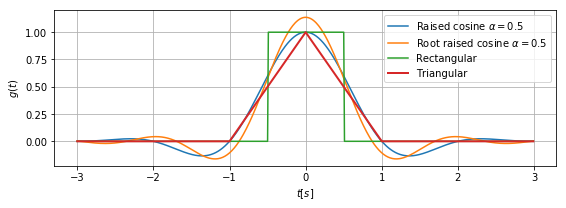

In [17]:
T = 1
Fs = 100
t = np.arange(-3*T, 3*T, 1/Fs)
g = get_filter('rc', T, rolloff=0.5)  # RC filter with rolloff alpha=0.5
plt.figure(figsize=(8,3))
plt.plot(t, get_filter('rc', T, rolloff=0.5)(t), label=r'Raised cosine $\alpha=0.5$')
plt.plot(t, get_filter('rrc', T, rolloff=0.5)(t), label=r'Root raised cosine $\alpha=0.5$')
plt.plot(t, get_filter('rect', T)(t), label=r'Rectangular')
plt.plot(t, get_filter('triang', T)(t), label=r'Triangular', lw=2)
plt.legend(fontsize=10);
plt.grid(True); plt.xlabel('$t [s]$'); plt.ylabel('$g(t)$')
plt.tight_layout();


Considerando alguns bits aleatórios $b$ e modulando no formato BPSK, os símbolos obtidos são $d$:

In [18]:
b = np.array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0])
d = 2*b-1
print ("d=%s" % d)

d=[-1  1  1 -1 -1  1  1 -1  1 -1 -1  1  1 -1  1 -1]


In [19]:
def get_signal(g, d):
    """Generate the transmit signal as sum(d[k]*g(t-kT))"""
    t = np.arange(-2*T, (len(d)+2)*T, 1/Fs)
    g0 = g(np.array([1e-8]))
    xt = sum(d[k]*g(t-k*T) for k in range(len(d)))
    return t, xt/g0

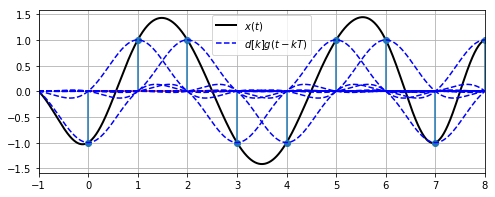

In [20]:
fig = plt.figure(figsize=(8,3))
t, xt = get_signal(g, d)
plt.plot(t, xt, 'k-', lw=2, label='$x(t)$')
plt.stem(T*np.arange(len(d)), d)
plt.grid(True)
plt.xlim((-1*T, 8*T))
for k in range(len(d)):
    if k == 0:
        plt.plot(t, d[k]*g(t-k*T), 'b--', label='$d[k]g(t-kT)$')
    else:
        plt.plot(t, d[k]*g(t-k*T), 'b--')
plt.legend();

In [21]:
def showEyeDiagramDrawing(xt, T, partInd):
    plt.gcf().clear()
    plt.subplot(211)
    plt.plot(t, xt, 'k-', lw=1, label='$x(t)$') # Plot the overall signal
    plt.xlim((-1, len(d)))
    plt.grid(True)
    plt.ylim((-1.5, 1.5))
    plt.xlabel('$t$')
    plt.ylabel('$x(t)$')
    
    sigStart = 2*T*Fs  # ignore some transient effects at the beginning of the signal
    samples_perT = Fs*T
    samples_perWindow = 2*T*Fs
    # extract the part of the signal we use for the current part of the eye diagram
    sig_part = xt[sigStart + samples_perT*partInd + np.arange(samples_perWindow)]
    t_emphasize = np.arange(2*T+T*partInd, 2*T+T*partInd+2*T, 1/Fs) + t.min()
    # mark the part of the signal that currently contributes to the eye diagram
    plt.plot(t_emphasize, sig_part, 'b-', lw=2)   
    plt.title('Signal')
    
    
    plt.subplot(235)
    t_part = np.arange(-T, T, 1/Fs)
    # draw all parts of the eye diagram from previous signal portions in black
    for p in range(partInd):
        plt.plot(t_part, xt[sigStart + samples_perT*p + np.arange(samples_perWindow)], 'k-')
    # draw the current part of the eye diagram in thick blue
    plt.plot(t_part, sig_part, 'b-', lw=2)
    plt.grid(True)
    plt.ylim((-1.5, 1.5)); plt.xlim((-1.1, 1.1)); plt.xlabel('$t$'); plt.ylabel('$x(t)$')
    plt.title('Eye diagram')
    plt.xticks([-1,0,1]); plt.yticks([-1, 0, 1])
    plt.tight_layout();
    showInInteract()

In [22]:
interact(lambda i: showEyeDiagramDrawing(xt, T, i), i=(0, 14));

interactive(children=(IntSlider(value=7, description='i', max=14), Output()), _dom_classes=('widget-interact',…

In [23]:
def drawFullEyeDiagram(xt):
    """Draw the eye diagram using all parts of the given signal xt"""
    samples_perT = Fs*T
    samples_perWindow = 2*Fs*T
    assert len(xt) % samples_perT == 0
    parts = []
    startInd = 2*samples_perT   # ignore some transient effects at beginning of signal
    
    for k in range(int(len(xt)/samples_perT) - 6):
        parts.append(xt[startInd + k*samples_perT + np.arange(samples_perWindow)])
    parts = np.array(parts).T
    
    t_part = np.arange(-T, T, 1/Fs)
    plt.plot(t_part, parts, 'b-')
    plt.xlabel('$t$')
    plt.ylabel('$x(t)$');
    plt.grid(True)
    
def drawSignals(g, data=None):
    """Draw the transmit signal, the used filter and the resulting eye-diagram
    into one figure."""
    N = 100;
    if data is None:
        data = 2*((np.random.randn(N)>0))-1
        # fix the first 10 elements for  keeping the shown graphs constant
        # between eye diagrams
        data[0:10] = 2*np.array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0])-1
    
    t, xt = get_signal(g, data)

    plt.subplot(223)
    t_g = np.arange(-4*T, 4*T, 1/Fs)
    plt.plot(t_g, g(t_g))
    plt.ylim((-0.2, 1.2)); plt.grid(True)
    plt.title('Filter $g(t)$')
    plt.xlabel('$t$')
    plt.ylabel('$g(t)$')

    
    plt.subplot(211)
    plt.plot(t, xt)
    plt.stem(data)
    plt.xlim((0, 8*T)); plt.ylim((-2,2))
    plt.title(r'Signal $x(t)=\sum_kd[k]g(t-kT)$')
    plt.xlabel('$t$'); plt.ylabel(r'$x(t)$'); plt.grid(True)
    
    plt.subplot(224)
    drawFullEyeDiagram(xt); plt.ylim((-2,2))
    plt.title('Eye diagram')
    plt.tight_layout()

In [24]:
def showRCEyeDiagram(alpha):
    g = get_filter('rc', T=1, rolloff=alpha)
    plt.gcf().clear()
    drawSignals(g)
    plt.subplot(211);
    plt.text(1, -1, r'RC, $\alpha=%.1f$' % alpha, bbox=dict(fc='white'));
    showInInteract()


C:\Users\Adolfo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


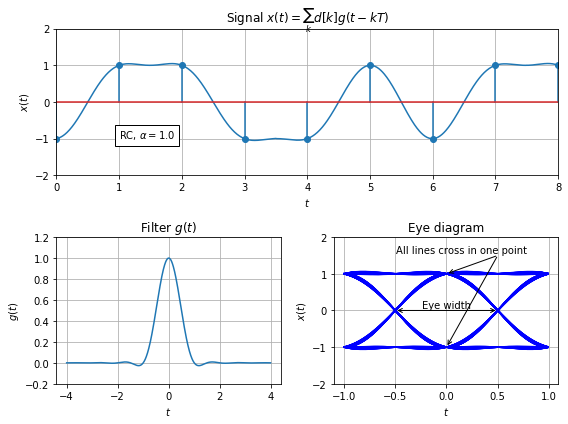

In [25]:
plt.figure(figsize=(8,6))
showRCEyeDiagram(alpha=1)
plt.subplot(224)
plt.annotate(s='', xy=(-0.5,0), xytext=(0.5,0), arrowprops=dict(arrowstyle='<->'), va='center')
plt.text(0, 0., 'Eye width', ha='center', va='bottom')
plt.annotate(s='', xy=(0, -1), xytext=(0.5, 1.5), arrowprops=dict(arrowstyle='->'))
plt.annotate(s='', xy=(0,  1), xytext=(0.5, 1.5), arrowprops=dict(arrowstyle='->'))
plt.text(0.15, 1.5, 'All lines cross in one point', va='bottom', ha='center');

In [26]:
interact(showRCEyeDiagram, alpha=(0., 1.));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

In [28]:
d = 2*np.array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]) - 1
print ("d=%s" % d)

d=[-1  1 -1 -1  1  1 -1  1 -1 -1 -1  1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1
  1 -1  1  1  1 -1  1]


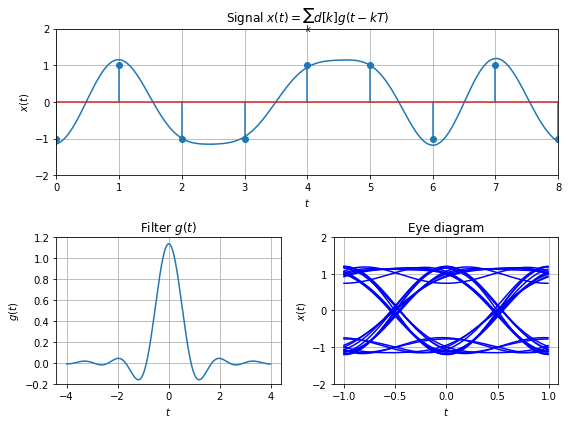

In [29]:
plt.figure(figsize=(8,6))
drawSignals(get_filter('rrc', T=1, rolloff=0.5), data=d)

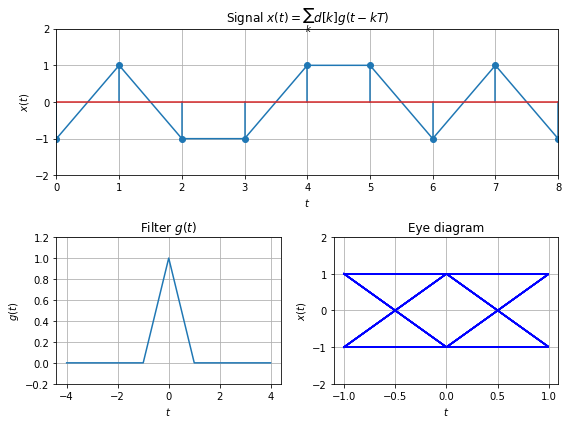

In [30]:
plt.figure(figsize=(8,6))
drawSignals(get_filter('triang', T=1), data=d)

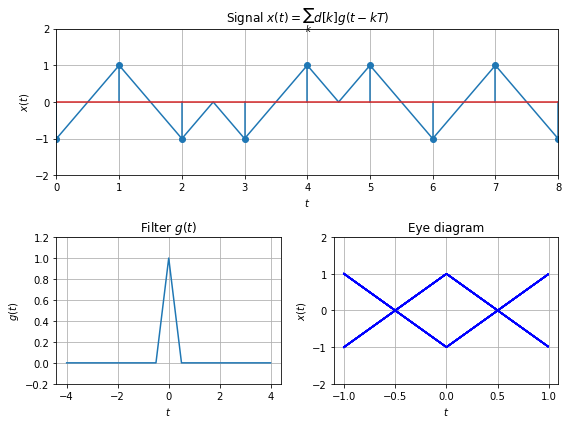

In [31]:
plt.figure(figsize=(8,6))
drawSignals(get_filter('triang', T=0.5, rolloff=0.5), data=d)

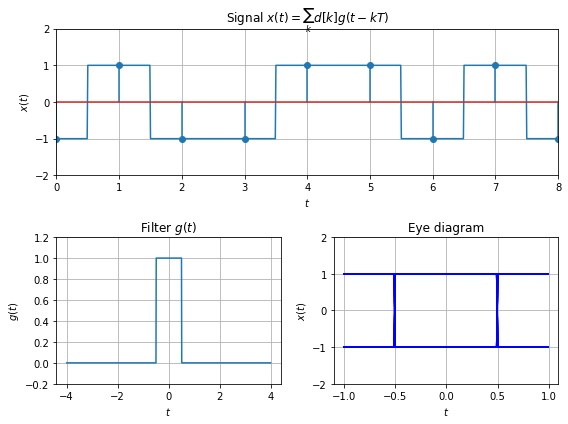

In [32]:
plt.figure(figsize=(8,6))
drawSignals(get_filter('rect', T=1, rolloff=0.5), data=d)

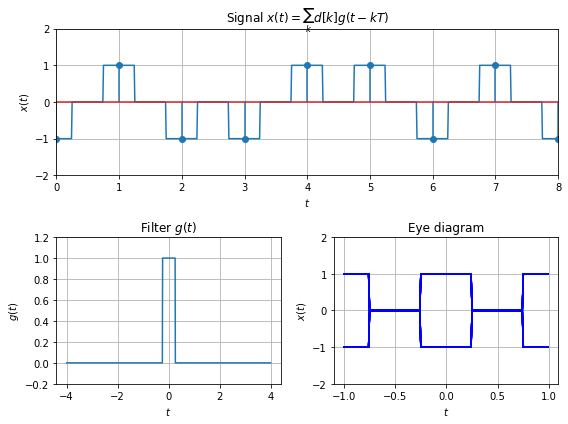

In [33]:
plt.figure(figsize=(8,6))
drawSignals(get_filter('rect', T=0.5, rolloff=0.5), data=d)

[ 3 -3 -3 -1  1 -1  1  1 -1  1]


C:\Users\Adolfo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


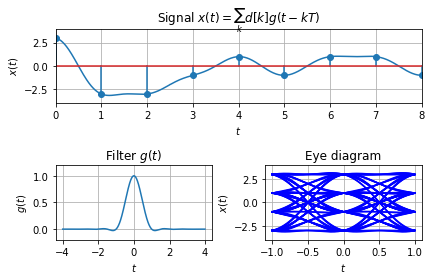

In [34]:
N = 100
data = 3-2*np.arange(4)[np.random.randint(4, size=N)]
print (data[:10])
drawSignals(get_filter('rc', T=1, rolloff=1), data=data)
plt.subplot(211); plt.ylim((-4,4));
plt.subplot(224); plt.ylim((-4,4));